In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve 
from sklearn.metrics import fbeta_score

### Basic info about dataset

In [2]:
df_train=pd.read_csv('data/data-training-02.csv')
df_test = pd.read_csv('data/data-testing-02.csv')

In [3]:
print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")

Train Shape: (768890, 29)
Test Shape: (164170, 29)


In [4]:
df_train.columns

Index(['weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'hour_sin', 'hour_cos', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_F', 'gender_M', 'amt_scaler', 'cardholder_age_scaler',
       'job_encoded', 'merchant_encoded', 'is_fraud'],
      dtype='object')

In [5]:
df_train.head()

,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,category_entertainment,category_food_dining,...,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,amt_scaler,cardholder_age_scaler,job_encoded,merchant_encoded,is_fraud
0,-0.781831,0.623490,-2.449294e-16,1.000000,0.998717,-0.050649,-0.707107,-0.707107,False,True,...,False,False,False,False,True,0.004064,0.134146,0.000000,0.001070,0
1,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.937752,0.347305,0.707107,-0.707107,False,False,...,True,False,False,False,True,0.002857,0.231707,0.010493,0.019666,0
2,-0.433884,-0.900969,5.000000e-01,-0.866025,-0.299363,-0.954139,0.965926,0.258819,False,False,...,False,False,False,True,False,0.002572,0.536585,0.000000,0.013051,0
3,-0.781831,0.623490,8.660254e-01,-0.500000,-0.897805,-0.440394,-0.500000,-0.866025,False,False,...,False,True,False,True,False,0.000003,0.414634,0.008911,0.013046,0
4,-0.433884,-0.900969,8.660254e-01,0.500000,-0.968077,-0.250653,-0.866025,0.500000,False,False,...,False,False,False,False,True,0.002574,0.329268,0.003142,0.001130,0


In [6]:
fraud_count = len(df_train[df_train['is_fraud'] == 1])
fraud_count

127434

In [7]:
# Training data and Testing data
X_train = df_train.drop(columns=['is_fraud']) 
y_train = df_train['is_fraud'] 

X_test = df_test.drop(columns=['is_fraud']) 
y_test = df_test['is_fraud'] 

### Logistic Regression 

>* Find optimal parameters using GridSearch

In [9]:
# Define the model
lr_model = LogisticRegression(solver='sag', max_iter=5000)  # choose solver

# Define the range of hyperparameters to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter ranges
}

# Search parameters using GridSearch
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring='recall',     
    cv=5,                   
    verbose=1,             
)

# Train
grid_search.fit(X_train, y_train)

# Output optimal parameters and scores
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 100}
Best CV Score: 0.8475445545139161


>* Fit the model and predict

In [55]:
lr_model = LogisticRegression(
    C=100,                  
    solver='sag',         
    max_iter=5000,          
    class_weight='balanced' 
)


lr_model.fit(X_train,y_train)


y_pred = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

>* Evaluate the model

In [11]:
cm_lr = confusion_matrix(y_test, y_pred)
class_report_lr = classification_report(y_test, y_pred)
f2_lr = fbeta_score(y_test, y_pred, beta=2)

print("Confusion Matrix:")
print(cm_lr)
print("\nClassification Report:")
print(class_report_lr)
print("\nf-2 score")
print(f2_lr)

Confusion Matrix:
[[153963   9277]
 [   195    735]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    163240
           1       0.07      0.79      0.13       930

    accuracy                           0.94    164170
   macro avg       0.54      0.87      0.55    164170
weighted avg       0.99      0.94      0.97    164170


f-2 score
0.2676230702009904


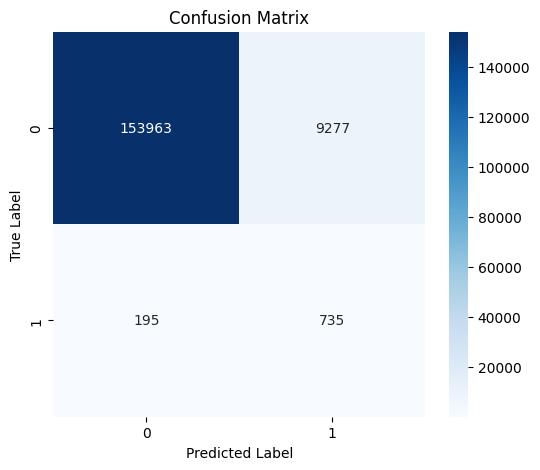

In [13]:
# Create a heatmap of confusion mareix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [56]:
# Calculate ROC curve
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_prob_lr)

# Calculate AUC
auc_lr = roc_auc_score(y_test, y_prob_lr)

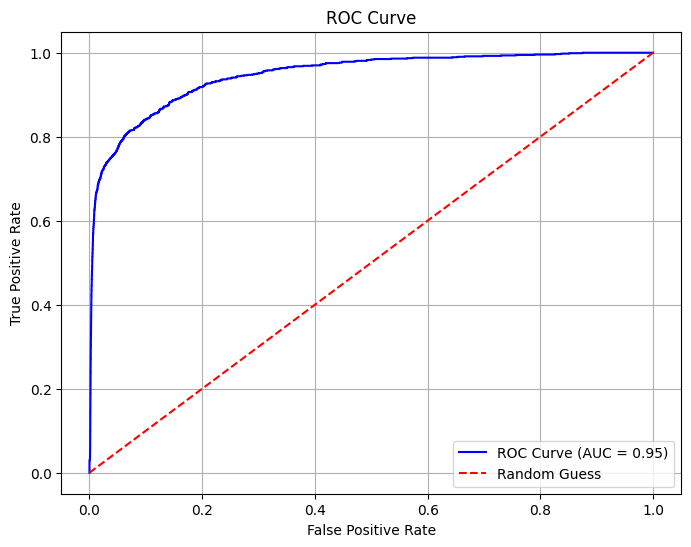

In [15]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [16]:
print(fpr, tpr, thresholds)
print(auc)


[0.00000000e+00 9.80151924e-05 4.83950012e-04 ... 8.74558932e-01
 8.74558932e-01 1.00000000e+00] [0.         0.02903226 0.02903226 ... 0.99892473 1.         1.        ] [           inf 1.00000000e+00 9.99999499e-01 ... 1.12815202e-03
 1.12807377e-03 8.86684212e-06]
0.9470107013092408


### Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
dt_model = DecisionTreeClassifier(
    splitter = 'random',
    random_state=123,
    class_weight={0: 1, 1: 15},    # Higher weight assigned to the fraud class
    max_depth=15,                  # Limit the depth of the tree
    min_samples_leaf=10,           # Leaf nodes must contain at least 5 samples
    min_samples_split=10           # The minimum number of samples required to split an internal node
)

In [50]:
dt_model.fit(X_train,y_train)

y_pred_class_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

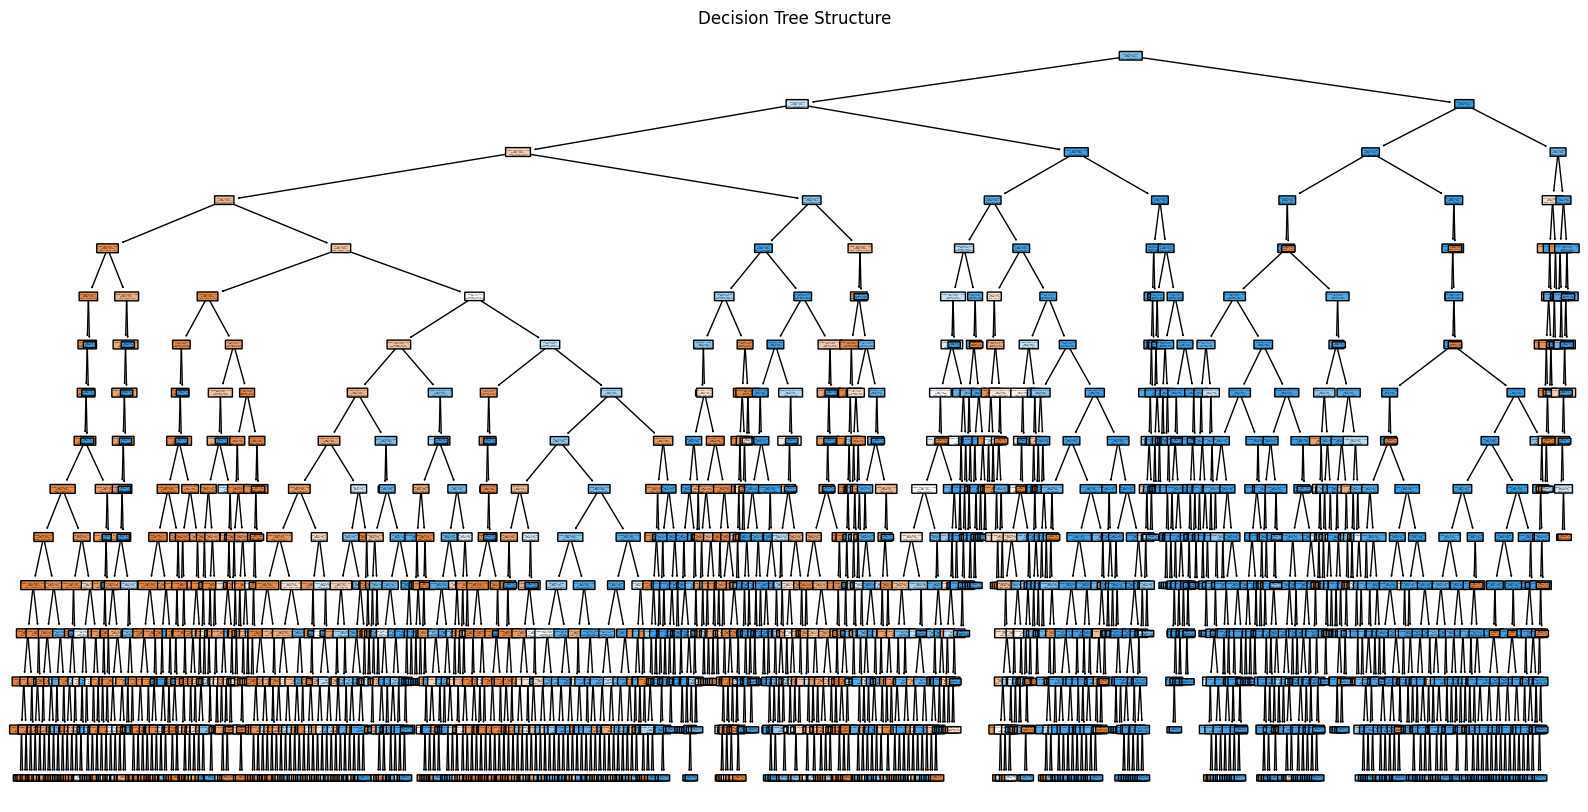

In [45]:
# Visualize Decision Tree as a Tree Structure
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Not Fraud', 'Fraud'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()

In [44]:
cm_dt = confusion_matrix(y_test, y_pred_class_dt)
class_report_dt = classification_report(y_test, y_pred_class_dt)
f2_dt = fbeta_score(y_test, y_pred_class_dt, beta=2)

print("Confusion Matrix:")
print(cm_dt)
print("\nClassification Report:")
print(class_report_dt)
print("\nf-2 score")
print(f2_dt)

Confusion Matrix:
[[155343   7897]
 [    77    853]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    163240
           1       0.10      0.92      0.18       930

    accuracy                           0.95    164170
   macro avg       0.55      0.93      0.58    164170
weighted avg       0.99      0.95      0.97    164170


f-2 score
0.34202085004009625


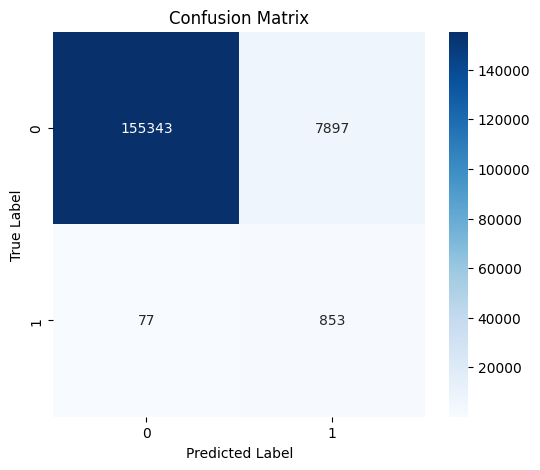

In [47]:
# Plot Confusion Matrix for Decision Tree
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

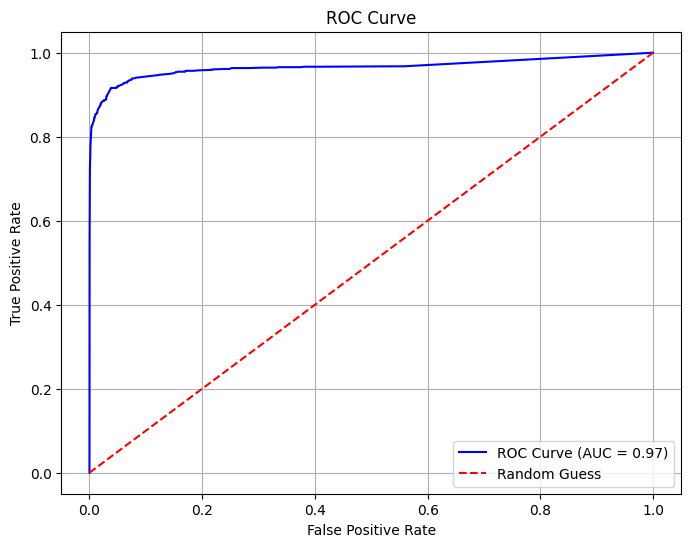

In [58]:
# Calculate ROC curve
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_prob_dt)

# Calculate AUC
auc_dt = roc_auc_score(y_test, y_prob_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f"ROC Curve (AUC = {auc_dt:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
# Define parameter distribution
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(50, 100, 10)],
    'max_depth': [10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [20, 50, 10],
    'min_samples_leaf': [10, 20, 40],
}

# Initialize random search
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=3, 
    scoring='recall', 
    verbose=1, 
    random_state=42)

# Search
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\zdn\ntu\info mining\env_im\.conda\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'n_estimators': 61, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 20}


In [19]:
# Modeling
rf_model = RandomForestClassifier(
    n_estimators=61,  
    max_depth=20,
    min_samples_split = 20,
    min_samples_leaf = 10,
    max_features = 'log2',
    random_state=42,
    class_weight='balanced'
)

# Train
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [20]:
# Evaluate the model
cm_rf = confusion_matrix(y_test, y_pred)
class_report_rf = classification_report(y_test, y_pred)
f2_rf = fbeta_score(y_test, y_pred, beta=2)

print("Confusion Matrix:")
print(cm_rf)
print("\nClassification Report:")
print(class_report_rf)
print("\nf-2 score")
print(f2_rf)

Confusion Matrix:
[[162478    762]
 [   171    759]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163240
           1       0.50      0.82      0.62       930

    accuracy                           0.99    164170
   macro avg       0.75      0.91      0.81    164170
weighted avg       1.00      0.99      0.99    164170


f-2 score
0.7240984544934173


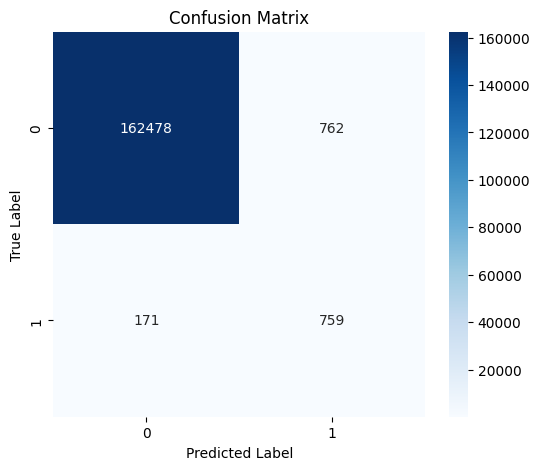

In [21]:
# Create a heatmap of confusion mareix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

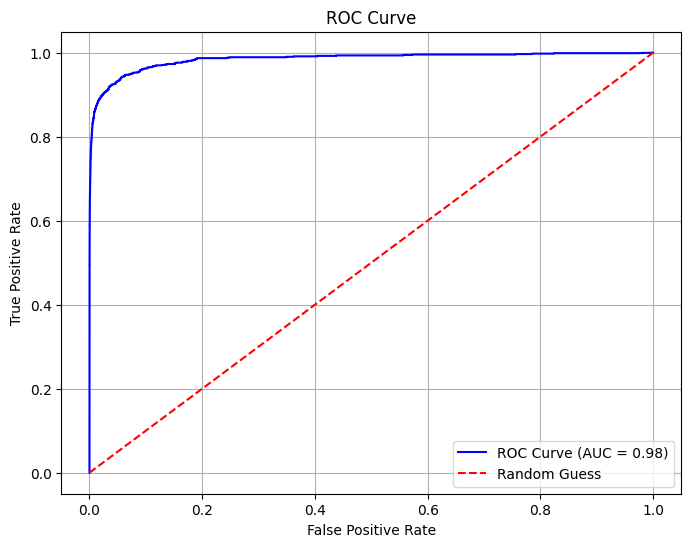

In [52]:
# Calculate ROC curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob_rf)

# Calculate AUC
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

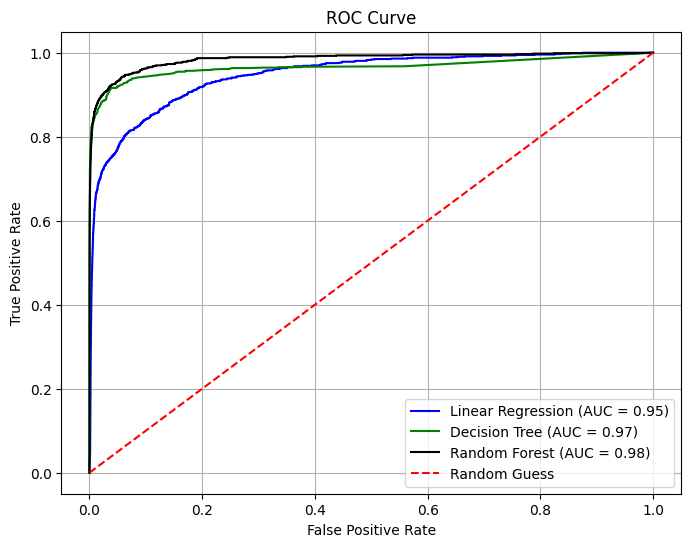

In [57]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Linear Regression (AUC = {auc_lr:.2f})", color="blue")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})", color="green")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color="black")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()